# TODO
[#2](https://github.com/caelum02/LuX-AI-Season-2/issues/2)
Observation to Input

In [14]:
import jux
from jux.env import JuxEnv
from jux.config import JuxBufferConfig
from jux.state import State
from jux.actions import JuxAction

import jax
import jax.numpy as jnp
from jax import jit, vmap, pmap, grad, random, lax
from jax.tree_util import tree_flatten, tree_unflatten, tree_map
from jax import random

from flax import linen as nn

import rich
import matplotlib.pyplot as plt

from utils import replay_run_early_phase, replay_run_n_late_game_step
import preprocess as pp

from importlib import reload


MAP_SIZE=64

In [3]:
lux_env, lux_actions = jux.utils.load_replay('https://www.kaggleusercontent.com/episodes/52900827.json')
jux_env, state = JuxEnv.from_lux(lux_env, buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))
state, lux_actions = replay_run_early_phase(jux_env, state, lux_actions)
state, lux_actions = replay_run_n_late_game_step(100, jux_env, state, lux_actions)

[Replay Util] Replaying early steps
[Replay Util] Replaying early steps - Done
[Replay Util] Replaying 1/100 steps
[Replay Util] Replaying 2/100 steps
[Replay Util] Replaying 3/100 steps
[Replay Util] Replaying 4/100 steps
[Replay Util] Replaying 5/100 steps
[Replay Util] Replaying 6/100 steps
[Replay Util] Replaying 7/100 steps
[Replay Util] Replaying 8/100 steps
[Replay Util] Replaying 9/100 steps
[Replay Util] Replaying 10/100 steps
[Replay Util] Replaying 11/100 steps
[Replay Util] Replaying 12/100 steps
[Replay Util] Replaying 13/100 steps
[Replay Util] Replaying 14/100 steps
[Replay Util] Replaying 15/100 steps
[Replay Util] Replaying 16/100 steps
[Replay Util] Replaying 17/100 steps
[Replay Util] Replaying 18/100 steps
[Replay Util] Replaying 19/100 steps
[Replay Util] Replaying 20/100 steps
[Replay Util] Replaying 21/100 steps
[Replay Util] Replaying 22/100 steps
[Replay Util] Replaying 23/100 steps
[Replay Util] Replaying 24/100 steps
[Replay Util] Replaying 25/100 steps
[Repl

In [4]:
rich.print(jax.tree_map(lambda x: getattr(x, 'aval'), state[4:]))

(
    Board(
        seed=ShapedArray(int32[]),
        factories_per_team=ShapedArray(int8[]),
        map=GameMap(
            rubble=ShapedArray(int8[64,64]),
            ice=ShapedArray(bool[64,64]),
            ore=ShapedArray(bool[64,64]),
            symmetry=ShapedArray(int8[])
        ),
        lichen=ShapedArray(int32[64,64]),
        lichen_strains=ShapedArray(int8[64,64]),
        units_map=ShapedArray(int16[64,64]),
        factory_map=ShapedArray(int8[64,64]),
        factory_occupancy_map=ShapedArray(int8[64,64]),
        factory_pos=ShapedArray(int8[22,2])
    ),
    Unit(
        unit_type=ShapedArray(int8[2,200]),
        action_queue=ActionQueue(
            data=UnitAction(
                action_type=ShapedArray(int8[2,200,20]),
                direction=ShapedArray(int8[2,200,20]),
                resource_type=ShapedArray(int8[2,200,20]),
                amount=ShapedArray(int16[2,200,20]),
                repeat=ShapedArray(int16[2,200,20]),
                n=ShapedArray(int16[2,200,20])
            ),
            front=ShapedArray(int8[2,200]),
            rear=ShapedArray(int8[2,200]),
            count=ShapedArray(int8[2,200])
        ),
        team_id=ShapedArray(int8[2,200]),
        unit_id=ShapedArray(int16[2,200]),
        pos=Position(pos=ShapedArray(int8[2,200,2])),
        cargo=UnitCargo(stock=ShapedArray(int32[2,200,4])),
        power=ShapedArray(int32[2,200])
    ),
    ShapedArray(int16[2000,2]),
    ShapedArray(int16[2]),
    Factory(
        team_id=ShapedArray(int8[2,11]),
        unit_id=ShapedArray(int8[2,11]),
        pos=Position(pos=ShapedArray(int8[2,11,2])),
        power=ShapedArray(int32[2,11]),
        cargo=UnitCargo(stock=ShapedArray(int32[2,11,4]))
    ),
    ShapedArray(int8[22,2]),
    ShapedArray(int8[2]),
    Team(
        team_id=ShapedArray(int8[2]),
        faction=ShapedArray(int8[2]),
        init_water=ShapedArray(int32[2]),
        init_metal=ShapedArray(int32[2]),
        factories_to_place=ShapedArray(int32[2]),
        factory_strains=ShapedArray(int8[2,11]),
        n_factory=ShapedArray(int8[2]),
        bid=ShapedArray(int32[2])
    ),
    ShapedArray(int16[]),
    ShapedArray(int8[])
)

In [47]:
from jux.unit import UnitType 
from jax import vmap, jit
from functools import partial


reload(pp)
unit_existence_map = pp.get_unit_existence(state.unit_mask, state.units.unit_type, state.units.pos.x, state.units.pos.y)

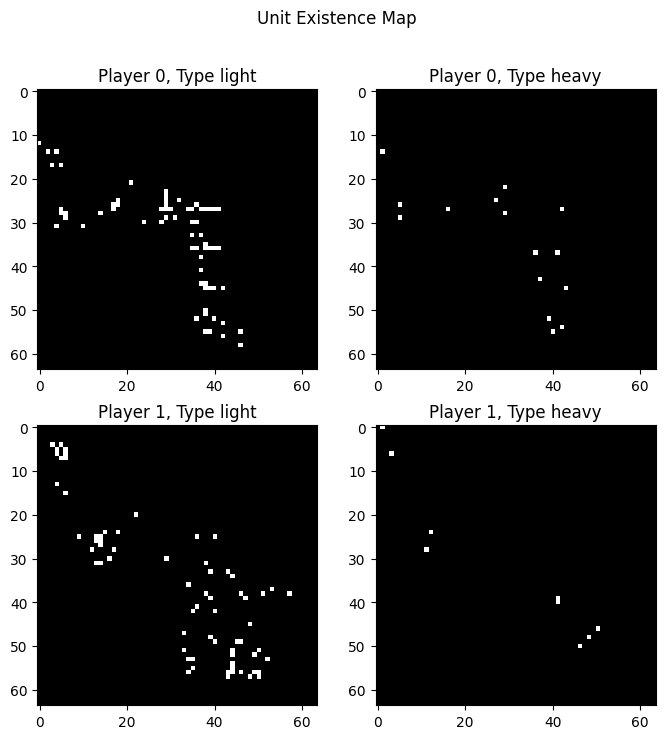

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
unit_type = ["light", "heavy"]
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(unit_existence_map[i, :, :, j], cmap='gray')
        axes[i, j].set_title(f"Player {i}, Type {unit_type[j]}")
fig.suptitle("Unit Existence Map")
plt.show()


In [54]:
reload(pp)
unit_resource_map = pp.get_unit_resource(state.units.cargo.stock, state.units.power, state.units.pos.x, state.units.pos.y)

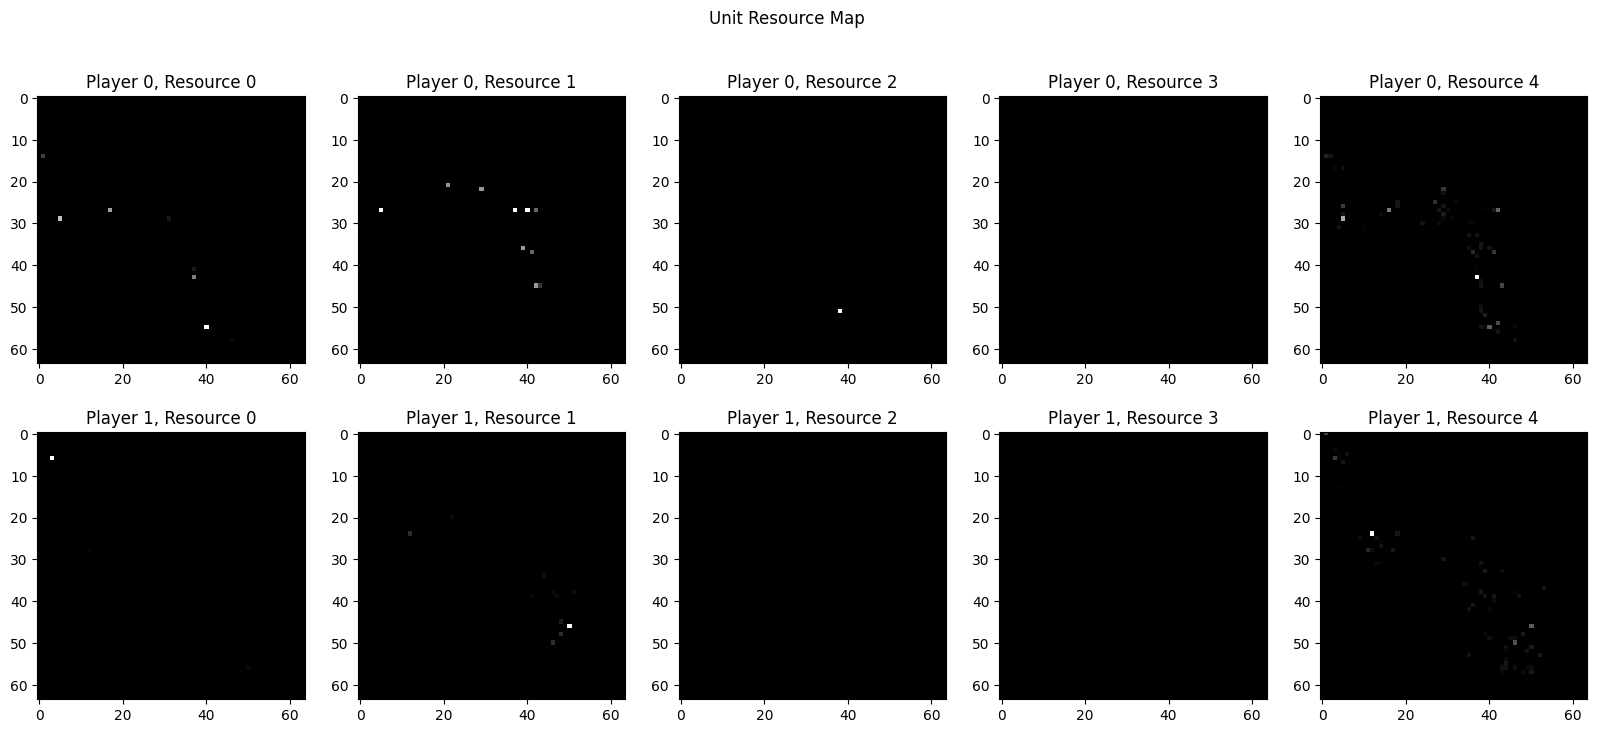

In [55]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(unit_resource_map[i, :, :, j], cmap='gray')
        axes[i, j].set_title(f"Player {i}, Resource {j}")
fig.suptitle("Unit Resource Map")
plt.show()

In [22]:
unit_map.aval

ShapedArray(float32[64,64,4])

#### Guarantees
```python
observations['player_0'] == observations['player_1'] == state
dones['player_0'] == dones['player_1']
infos['player_0'] == infos['player_1'] == {}
```

## Understanding the `State`

`State` object is a nested `NamedTuple`, with all leaves being `jax.numpy.ndarray`. It has following fields. 

In [14]:
state._fields

('env_cfg',
 'seed',
 'rng_state',
 'env_steps',
 'board',
 'units',
 'unit_id2idx',
 'n_units',
 'factories',
 'factory_id2idx',
 'n_factories',
 'teams',
 'global_id',
 'place_first')

### Board Information

Information about the board, including rubble, ice, ore, and lichen, are stored in `state.board`.

In [13]:
import jux.tree_util
import rich
rich.print(jux.tree_util.map_to_aval(state.board))

Board(
    seed=ShapedArray(int32[]),
    factories_per_team=ShapedArray(int8[]),
    map=GameMap(
        rubble=ShapedArray(int8[48,48]),
        ice=ShapedArray(bool[48,48]),
        ore=ShapedArray(bool[48,48]),
        symmetry=ShapedArray(int8[])
    ),
    lichen=ShapedArray(int32[48,48]),
    lichen_strains=ShapedArray(int8[48,48]),
    units_map=ShapedArray(int16[48,48]),
    factory_map=ShapedArray(int8[48,48]),
    factory_occupancy_map=ShapedArray(int8[48,48]),
    factory_pos=ShapedArray(int8[22,2])
)

### Factory Information

All information about factories, including their position, cargo, and power, are stored in `state.factories`. `state.n_factories` indicates the number of factories each player has. Because we have just reset the environment, both players have 0 factory. The leaves of `state.factories` have shapes shown as below. 

In [14]:
print(f"{state.n_factories = }")
rich.print(jux.tree_util.map_to_aval(state.factories))

state.n_factories = Array([2, 2], dtype=int8)


Factory(
    team_id=ShapedArray(int8[2,11]),
    unit_id=ShapedArray(int8[2,11]),
    pos=Position(pos=ShapedArray(int8[2,11,2])),
    power=ShapedArray(int32[2,11]),
    cargo=UnitCargo(stock=ShapedArray(int32[2,11,4]))
)